# Style Transfer - Adding the histogram loss and gradient

Here, I aim to define a histogram - matching map, and use it to calculate a histogram loss and gradient. 

The ultimate aim is to implement [Stable and Controllable Neural Texture Synthesis and Style Transfer Using Histogram Losses](https://arxiv.org/abs/1701.08893); this histogram loss is the first step

In [1]:
% matplotlib inline

import numpy as np 

import matplotlib.pyplot as plt

import scipy
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from VGG16 import VGG16

from keras.models import Model
from keras.metrics import mse

from keras import backend as K

from PIL import Image


Using TensorFlow backend.


In [2]:
def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

In [3]:
limit_mem()

## Loading the data

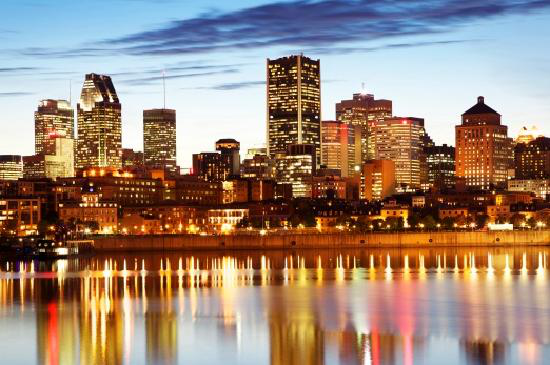

In [4]:
content = Image.open('images/inputs/content/downtown-montreal.jpg')
content

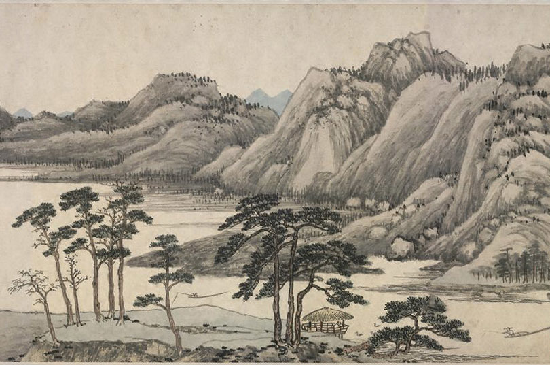

In [5]:
style = Image.open('images/inputs/style/fuchun-mountains.jpg').resize(content.size)
style

## Preprocessing the Images

In [6]:
def image_preprocess(img_ar):
    '''
    Input: image as numpy array
    Output: preprocessed image as numpy array
    '''
    resnet_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
    exp_img_ar = np.expand_dims(np.array(img_ar), 0)
    proc_img_ar = (exp_img_ar - resnet_mean)[:,:,:,::-1]
    return proc_img_ar
#end

def image_postprocess(img_ar, shp):
    '''Input: preprocessed image as numpy array
       Output: postprocessed image as numpy array
    '''
    resnet_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
    postpr_img_ar = np.clip(img_ar.reshape(shp)[:,:,:,::-1] + resnet_mean, 0, 255)
    return postpr_img_ar
#end

In [7]:
content_array = image_preprocess(content)

In [8]:
style_array = image_preprocess(style)

In [9]:
image_array_shape = content_array.shape

## Defining the loss functions

Lets just have the histogram loss function, to see its effects

In [10]:
def hist_match(source, template):
    shape = K.tf.shape(source)
    source = K.flatten(source)
    template = K.flatten(template)
    # get the set of unique pixel values and their corresponding indices and
    # counts

    hist_bins = 255

    # Defining the 'x_axis' of the histogram

    max_value = K.tf.reduce_max([K.tf.reduce_max(source), K.tf.reduce_max(template)])
    min_value = K.tf.reduce_min([K.tf.reduce_min(source), K.tf.reduce_min(template)])

    hist_delta = (max_value - min_value)/hist_bins

    # Getting the x-axis for each value
    hist_range = K.tf.range(min_value, max_value, hist_delta)
    # I don't want the bin values; instead, I want the average value of each bin, which is 
    # lower_value + hist_delta/2
    hist_range = K.tf.add(hist_range, K.tf.divide(hist_delta, 2))

    # Now, making fixed width histograms on this hist_axis 

    s_hist = K.tf.histogram_fixed_width(source, 
                                        [min_value, max_value],
                                         nbins = hist_bins, 
                                        dtype = K.tf.int64
                                        )


    t_hist = K.tf.histogram_fixed_width(template, 
                                         [min_value, max_value],
                                         nbins = hist_bins, 
                                        dtype = K.tf.int64
                                        )

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = K.tf.cumsum(s_hist)
    s_last_element = K.tf.subtract(K.tf.size(s_quantiles), K.tf.constant(1))
    s_quantiles = K.tf.divide(s_quantiles, K.tf.gather(s_quantiles, s_last_element))

    t_quantiles = K.tf.cumsum(t_hist)
    t_last_element = K.tf.subtract(K.tf.size(t_quantiles), K.tf.constant(1))
    t_quantiles = K.tf.divide(t_quantiles, K.tf.gather(t_quantiles, t_last_element))


    nearest_indices = K.tf.map_fn(lambda x: K.tf.argmin(K.tf.abs(K.tf.subtract(t_quantiles, x))), 
                                  s_quantiles, dtype = K.tf.int64)

    # Finding the correct s-histogram bin for every element in source
    s_bin_index = K.tf.to_int64(K.tf.divide(source, hist_delta))



    ## In the case where an activation function of 0-1 is used, then there might be some index exception errors. 
    ## This is to deal with those
    s_bin_index = K.tf.clip_by_value(s_bin_index, 0, 254)

    # Matching it to the correct t-histogram bin, and then making it the correct shape again
    matched_to_t = K.tf.gather(hist_range, K.tf.gather(nearest_indices, s_bin_index))
    return K.tf.reshape(matched_to_t, shape)

In [11]:
def hist_loss(calculated, target):
    if isinstance(calculated, list):
        histogram = ([hist_match(calc, targ)
                   for calc,  targ in zip(calculated, target)])
        print ("histogram is " + str(histogram))
        loss = sum([K.sum(mse(calc,hist))
                   for calc,  hist in zip(calculated, histogram)])
    else: 
        histogram = hist_match(calculated, target)
        loss = K.sum(mse(calculated,histogram))
    return loss

## Getting the targets

In [12]:
def get_hist_targets(style_transfer_model, style_ar):
    '''Input: style transfer model and numpy array of the style image
       Output: the output of the model at the histogram layers, and its respective target
    '''
    layer_output_dc = {l.name: l.get_output_at(0) for l in style_transfer_model.layers}
    hist_layer_ls = [layer_output_dc['block{}_conv1'.format(b)] for b in [1,4]] # ,4 
    hist_model = Model(style_transfer_model.input, hist_layer_ls)
    hist_targ_ls = [K.variable(o) for o in hist_model.predict(style_ar)]
    return hist_layer_ls, hist_targ_ls

In [19]:
class Evaluator(object):
    '''
    Initialization: function and shape of the image array
    Returns the loss and the gradients as computed with
       respect to the image that is fed to the CNN
    '''
    def __init__(self, f, shp):
        self.f = f
        self.shp = shp
        return
    #end        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    #end
    def grads(self, x): 
        return self.grad_values.flatten().astype(np.float64)
    #end    
#end

In [13]:
transfer_model = VGG16(pooling = 'Average', include_top =False, input_shape = image_array_shape[1:])

In [26]:
hist_layer_ls, hist_targ_ls = get_hist_targets(transfer_model, style_array)

In [27]:
hist_layer_ls, hist_targ_ls

([<tf.Tensor 'block1_conv1_1/Relu:0' shape=(?, 365, 550, 64) dtype=float32>,
  <tf.Tensor 'block4_conv1_1/Relu:0' shape=(?, 45, 68, 512) dtype=float32>],
 [<tf.Variable 'Variable_7:0' shape=(1, 365, 550, 64) dtype=float32_ref>,
  <tf.Variable 'Variable_8:0' shape=(1, 45, 68, 512) dtype=float32_ref>])

In [29]:
loss = hist_loss(hist_layer_ls, hist_targ_ls)

histogram is [<tf.Tensor 'Reshape_8:0' shape=(?, 365, 550, 64) dtype=float32>, <tf.Tensor 'Reshape_11:0' shape=(?, 45, 68, 512) dtype=float32>]


In [31]:
hist_grad = K.gradients(loss, transfer_model.input)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [32]:
hist_grad

[<tf.Tensor 'gradients/block1_conv1_1/convolution_grad/Conv2DBackpropInput:0' shape=(?, 365, 550, 3) dtype=float32>]

Omg this might work. 

## Step by Step through the method

Making an actual layer_ls tensor, instead of a placeholder

In [14]:
outputs = {l.name: l.get_output_at(0) for l in transfer_model.layers}
layers = [outputs['block{}_conv1'.format(b)] for b in [1,4]] # ,4 

In [15]:
hist_model = Model(transfer_model.input, layers)

In [16]:
style_targ_ls = [K.variable(o) for o in hist_model.predict(style_array)]

In [17]:
content_ls = [K.variable(o) for o in hist_model.predict(content_array)]

A handy method to check if everything is working 

In [18]:
def print_numpy(tens, print_output = False):
    with K.tf.Session() as sess: 
        coord = K.tf.train.Coordinator()
        threads = K.tf.train.start_queue_runners(sess=sess, coord=coord)
        sess.run(K.tf.global_variables_initializer())
        array = tens.eval()
        if print_output:
            print (array)
        return array

Let's use this to see where histogram_match SNAFUs

#### The stuff that works

(I went through the hist_match method step by step. Now that everything works, it is all in one cell. Yay!) 

In [39]:
source = content_ls[1]
template = style_targ_ls[1]

In [40]:
shape = K.tf.shape(source)
source = K.flatten(source)
template = K.flatten(template)
# get the set of unique pixel values and their corresponding indices and
# counts

hist_bins = 255

# Defining the 'x_axis' of the histogram

max_value = K.tf.reduce_max([K.tf.reduce_max(source), K.tf.reduce_max(template)])
min_value = K.tf.reduce_min([K.tf.reduce_min(source), K.tf.reduce_min(template)])

hist_delta = (max_value - min_value)/hist_bins

# Getting the x-axis for each value
hist_range = K.tf.range(min_value, max_value, hist_delta)
# I don't want the bin values; instead, I want the average value of each bin, which is 
# lower_value + hist_delta/2
hist_range = K.tf.add(hist_range, K.tf.divide(hist_delta, 2))

# Now, making fixed width histograms on this hist_axis 

s_hist = K.tf.histogram_fixed_width(source, 
                                    [min_value, max_value],
                                     nbins = hist_bins, 
                                    dtype = K.tf.int64
                                    )


t_hist = K.tf.histogram_fixed_width(template, 
                                     [min_value, max_value],
                                     nbins = hist_bins, 
                                    dtype = K.tf.int64
                                    )

# take the cumsum of the counts and normalize by the number of pixels to
# get the empirical cumulative distribution functions for the source and
# template images (maps pixel value --> quantile)
s_quantiles = K.tf.cumsum(s_hist)
s_last_element = K.tf.subtract(K.tf.size(s_quantiles), K.tf.constant(1))
s_quantiles = K.tf.divide(s_quantiles, K.tf.gather(s_quantiles, s_last_element))

t_quantiles = K.tf.cumsum(t_hist)
t_last_element = K.tf.subtract(K.tf.size(t_quantiles), K.tf.constant(1))
t_quantiles = K.tf.divide(t_quantiles, K.tf.gather(t_quantiles, t_last_element))


nearest_indices = K.tf.map_fn(lambda x: K.tf.argmin(K.tf.abs(K.tf.subtract(t_quantiles, x))), 
                              s_quantiles, dtype = K.tf.int64)

# Finding the correct s-histogram bin for every element in source
s_bin_index = K.tf.to_int64(K.tf.divide(source, hist_delta))



## In the case where an activation function of 0-1 is used, then there might be some index exception errors. 
## This is to deal with those
s_bin_index = K.tf.clip_by_value(s_bin_index, 0, 254)

# Matching it to the correct t-histogram bin, and then making it the correct shape again
matched_to_t = K.tf.gather(hist_range, K.tf.gather(nearest_indices, s_bin_index))
last_tensor = K.tf.reshape(matched_to_t, shape)

## Comparing Histograms

Now, to see the outputs, lets use the print_numpy method to turn the tensors into numpy arrays, which I can easily plot. 

In [25]:
hist_range_array = print_numpy(hist_range)

In [26]:
s_hist_org = print_numpy(s_hist)

In [27]:
t_hist_array = print_numpy(t_hist)

Now, making a histogram from the output 'matched' tensor

In [28]:
new_hist = K.tf.histogram_fixed_width(matched_to_t, 
                                     [min_value, max_value],
                                     nbins = hist_bins, 
                                    dtype = K.tf.int64
                                    )

Making it into a numpy array

In [29]:
new_hist_array = print_numpy(new_hist)

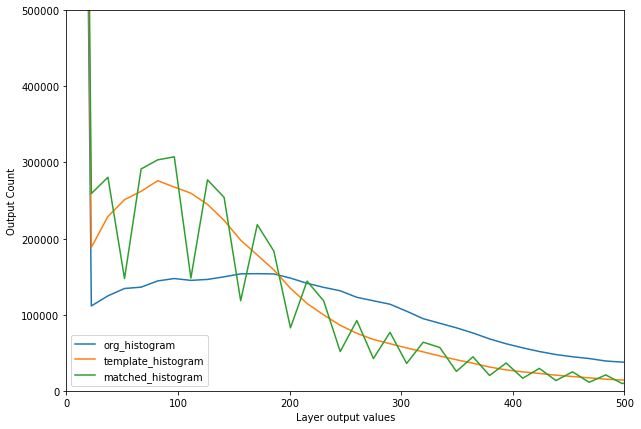

In [30]:
plt.figure(figsize =(10,7))
plt.plot(hist_range_array, s_hist_org, label = 'org_histogram')
plt.plot(hist_range_array, t_hist_array, label = 'template_histogram')
plt.plot(hist_range_array, new_hist_array, label = 'matched_histogram')
plt.xlabel("Layer output values")
plt.ylabel("Output Count")
plt.legend()
plt.xlim(xmin = 0, xmax = 500)
plt.ylim(ymin = 0, ymax = 500000)
plt.show()

Awesome! So the histogram matching works; the steppiness of the matched histogram has to do with the size of the buckets, and the fact that nearest neighbours is used to find the correct bins when making the matched histograms.

## Calculating the losses

In [19]:
test_loss = hist_loss(content_ls[0], style_targ_ls[0])

In [20]:
test_loss_0 = print_numpy(test_loss, print_output = True)

1.28461e+08


Note: this is not a gradient in itself. What I have calculated is a constant value, which can be added to the per-pixel gradient. Therefore, it has to be added to $L_{gram}$; its a stabilizing thing, but by itself cannot be a loss. 

Also, this gradient and loss are *much* larger than the ones calculated by the gram matrix and the content loss, which start at 3e+07 (for all layers). I am therefore going to divide both the loss and the gradient by 100, to ensure they do not overwhelm the other loss functions when implementing them into my neural network. 